In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
import numpy as np
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull
from pathlib import Path

DB_EPS = 20
DB_MIN_SAMPLES = 1

def frame_counts(csv_file, frames):
    spots = pd.read_csv(csv_file, skiprows=[1, 2, 3], low_memory=False)
    if not isinstance(frames, list):
        frames = [frames]
    counts = []
    for f in frames:
        counts.append(len(spots[spots["FRAME"] == f]))
    return counts

def frame_clusters_with_dbscan(csv_file, frame, db_eps=DB_EPS, db_min_sample=DB_MIN_SAMPLES):
    spots = pd.read_csv(csv_file, skiprows=[1, 2, 3], low_memory=False)
    spots_frame = spots[spots["FRAME"] == frame]
    pos_x = spots_frame["POSITION_X"].values
    pos_y = spots_frame["POSITION_Y"].values
    pos = np.vstack((pos_x, pos_y)).T
    if len(pos) == 0:
        return 0, pos, []
    clustering = DBSCAN(eps=DB_EPS, min_samples=DB_MIN_SAMPLES).fit(pos)
    num_clusters = len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0)
    return num_clusters, pos, clustering.labels_

def plot_clusters(ax, img, frame, pos, labels):
    with tifffile.TiffFile(img) as tif:
        frame_img = tif.pages[frame*2].asarray()
    ax.imshow(frame_img, cmap="gray")
    for label in set(labels):
        if label == -1:
            continue
        cluster_pos = pos[labels == label]
        if len(cluster_pos) < 3:
            print("Skipping cluster with less than 3 points: ", img)
            continue
        hull = ConvexHull(cluster_pos)
        ax.plot(cluster_pos[hull.vertices, 0], cluster_pos[hull.vertices, 1], "r-")

def get_files_list(root):
    root = Path(root)
    return [root/f for f in os.listdir(root) if not f.startswith('.')]

In [10]:
def plot_group_statistics_all_together(csv_files, normalizing_frame, names, title, savepath=None):

    timepoints = np.arange(0, 46)

    # compute inf counts for all frames
    all_counts = []
    normalized_counts = []
    for csv_group in csv_files:
        normalized_counts_group = []
        counts_group = []
        for csv_file in csv_group:
            # num_cluster, _, _ = frame_clusters_with_dbscan(csv_file, 4, db_eps, db_min_sample)
            counts = frame_counts(csv_file, list(timepoints))
            counts_group.append(counts)
            normalized_counts_group.append([c / counts[normalizing_frame] for c in counts])
        normalized_counts.append(normalized_counts_group)
        all_counts.append(counts_group)
    
    linestyles = ['-', '--', '*', '-*']
    colors = ['blue', 'orange', 'green', 'black']
    
    plt.figure(figsize=(15, 15))
    cm = plt.get_cmap('gist_rainbow')
    for i, group_counts in enumerate(all_counts):
        linestyle = linestyles[i]
        for j in range(len(group_counts)):
            plt.plot(group_counts[j], label=names[i] + '/' + csv_files[i][j].name.split('-')[0], linestyle=linestyle, color=cm(1.0 * j / len(group_counts)))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("Inf Counts for every frame, every sample")
    
    # Calculate mean and standard deviation for each group
    means = [np.mean(group_counts, axis=0) for group_counts in normalized_counts]
    stds = [np.std(group_counts, axis=0) for group_counts in normalized_counts]

    # Plot group statistics
    plt.figure(figsize=(15, 15))
    for g in range(len(means)):
        plt.plot(timepoints, means[g], label=names[g], linestyle=linestyles[g], color=colors[g])
        plt.fill_between(timepoints, means[g] - stds[g], means[g] + stds[g], alpha=0.3, color=colors[g])
    
    # Add legend
    plt.xlabel('Frames')
    plt.ylabel(f'Number of infected cells, normalized by number of infections at frame {normalizing_frame+1}')
    plt.title(title)
    plt.legend()
    
    # Show plot
    if savepath:
        plt.savefig(savepath, format="pdf")
    plt.show()

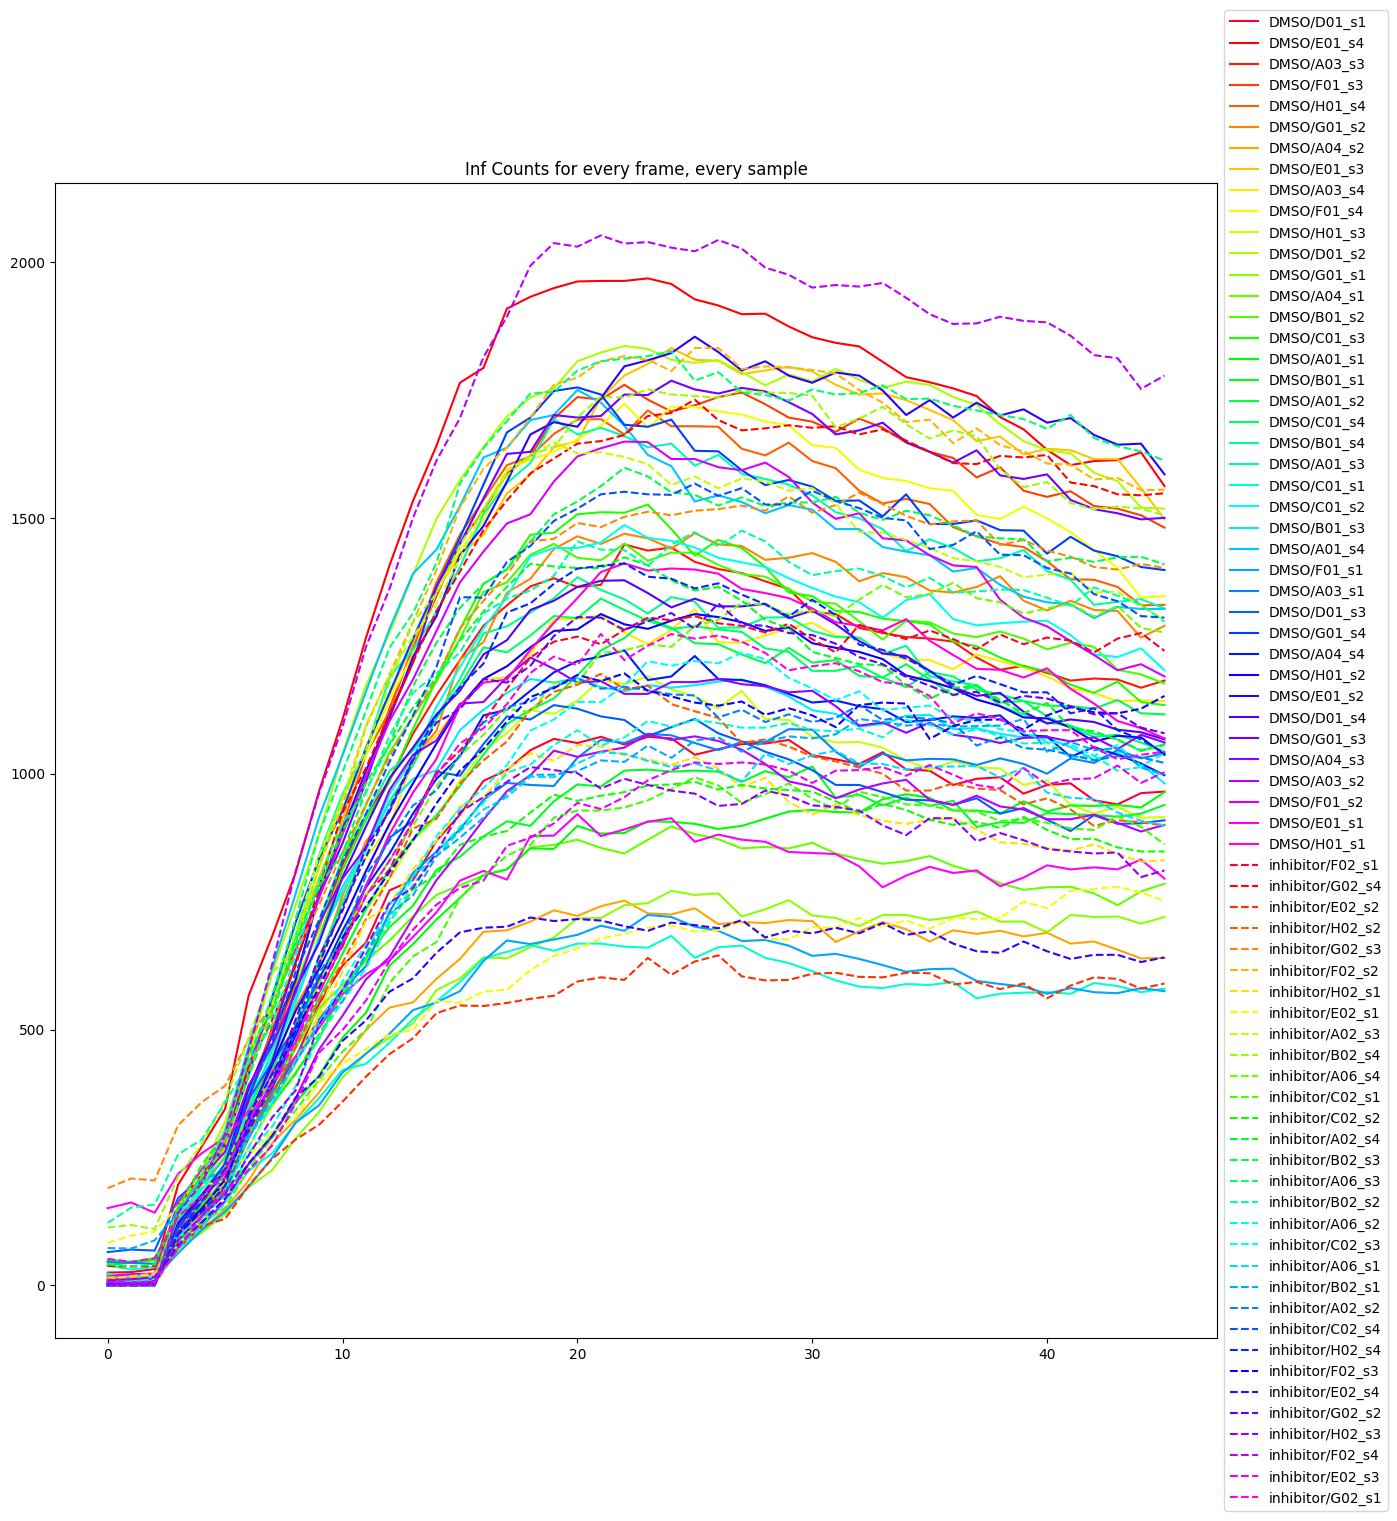

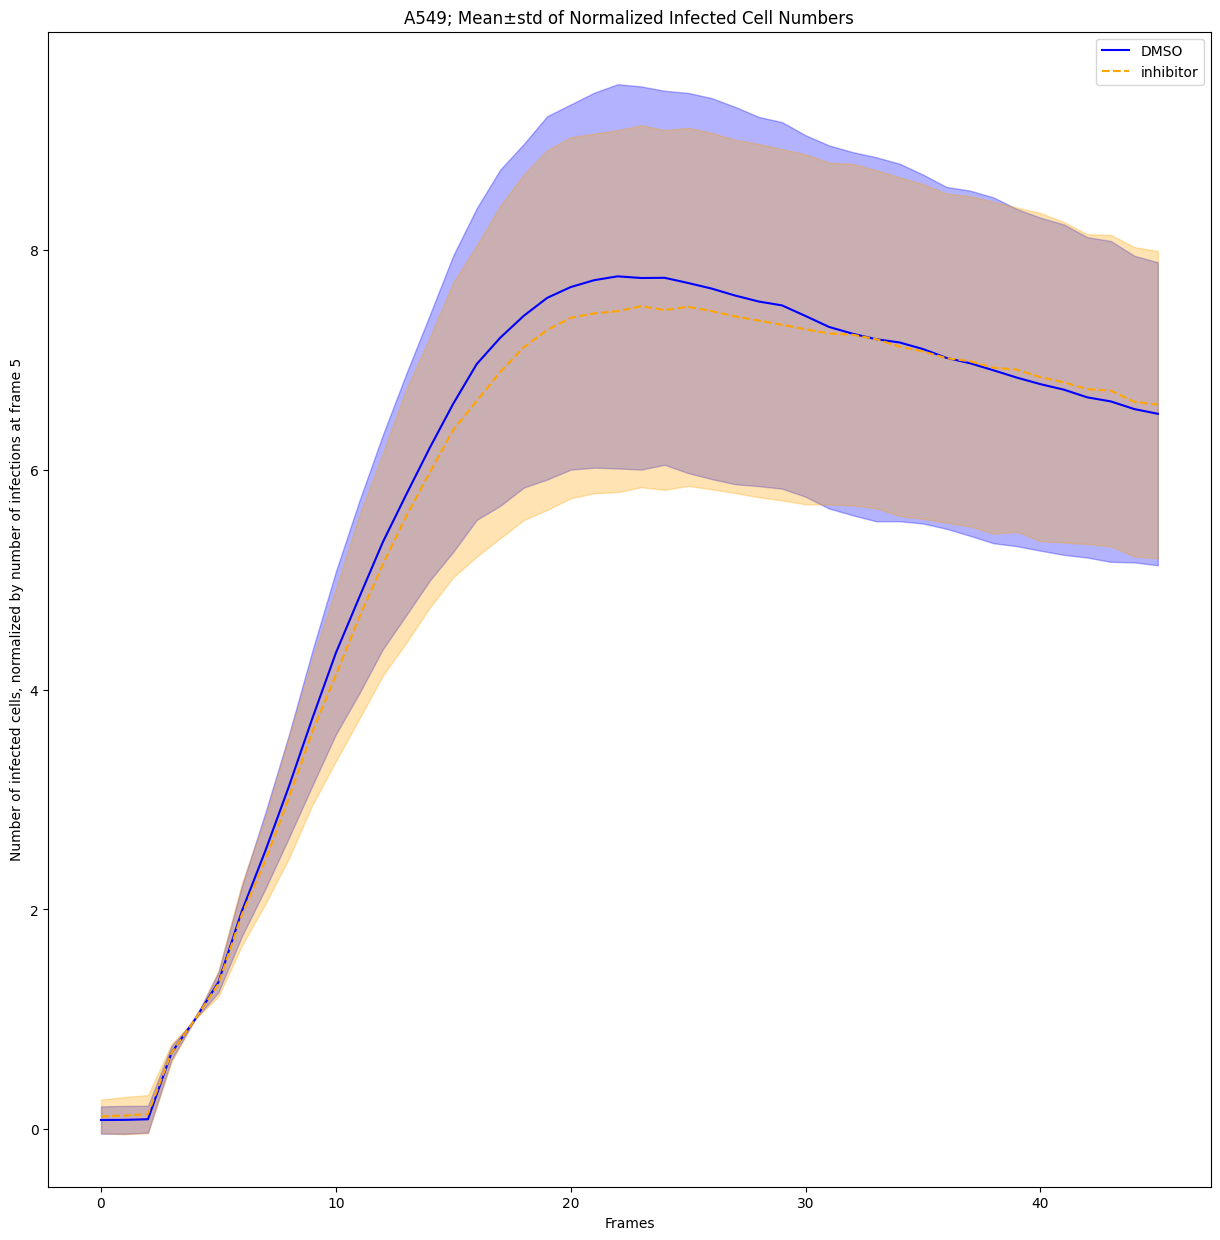

In [11]:
NORMALIZING_FRAME = 4

PROJECT_ROOT = Path("/Users/ashkanhzdr/workspace/ViralTally")
DATASET_ROOT = PROJECT_ROOT / "dataset" / "Sars2Plaque"
SAVE_ROOT = PROJECT_ROOT / "output"
os.makedirs(SAVE_ROOT, exist_ok=True)

dmso_csv_files = get_files_list(DATASET_ROOT / "trackmate" / "ACE2_A549_DMSO_wo_bg")
inhibitor_csv_files = get_files_list(DATASET_ROOT / "trackmate" / "ACE2_A549_inhibitor_wo_bg")

plot_group_statistics_all_together([dmso_csv_files, inhibitor_csv_files], normalizing_frame=NORMALIZING_FRAME, names=["DMSO", 'inhibitor'], title="A549; Mean±std of Normalized Infected Cell Numbers", savepath=SAVE_ROOT/f'A549-frame{NORMALIZING_FRAME}-normalized-wo-bg.pdf')

# Vero

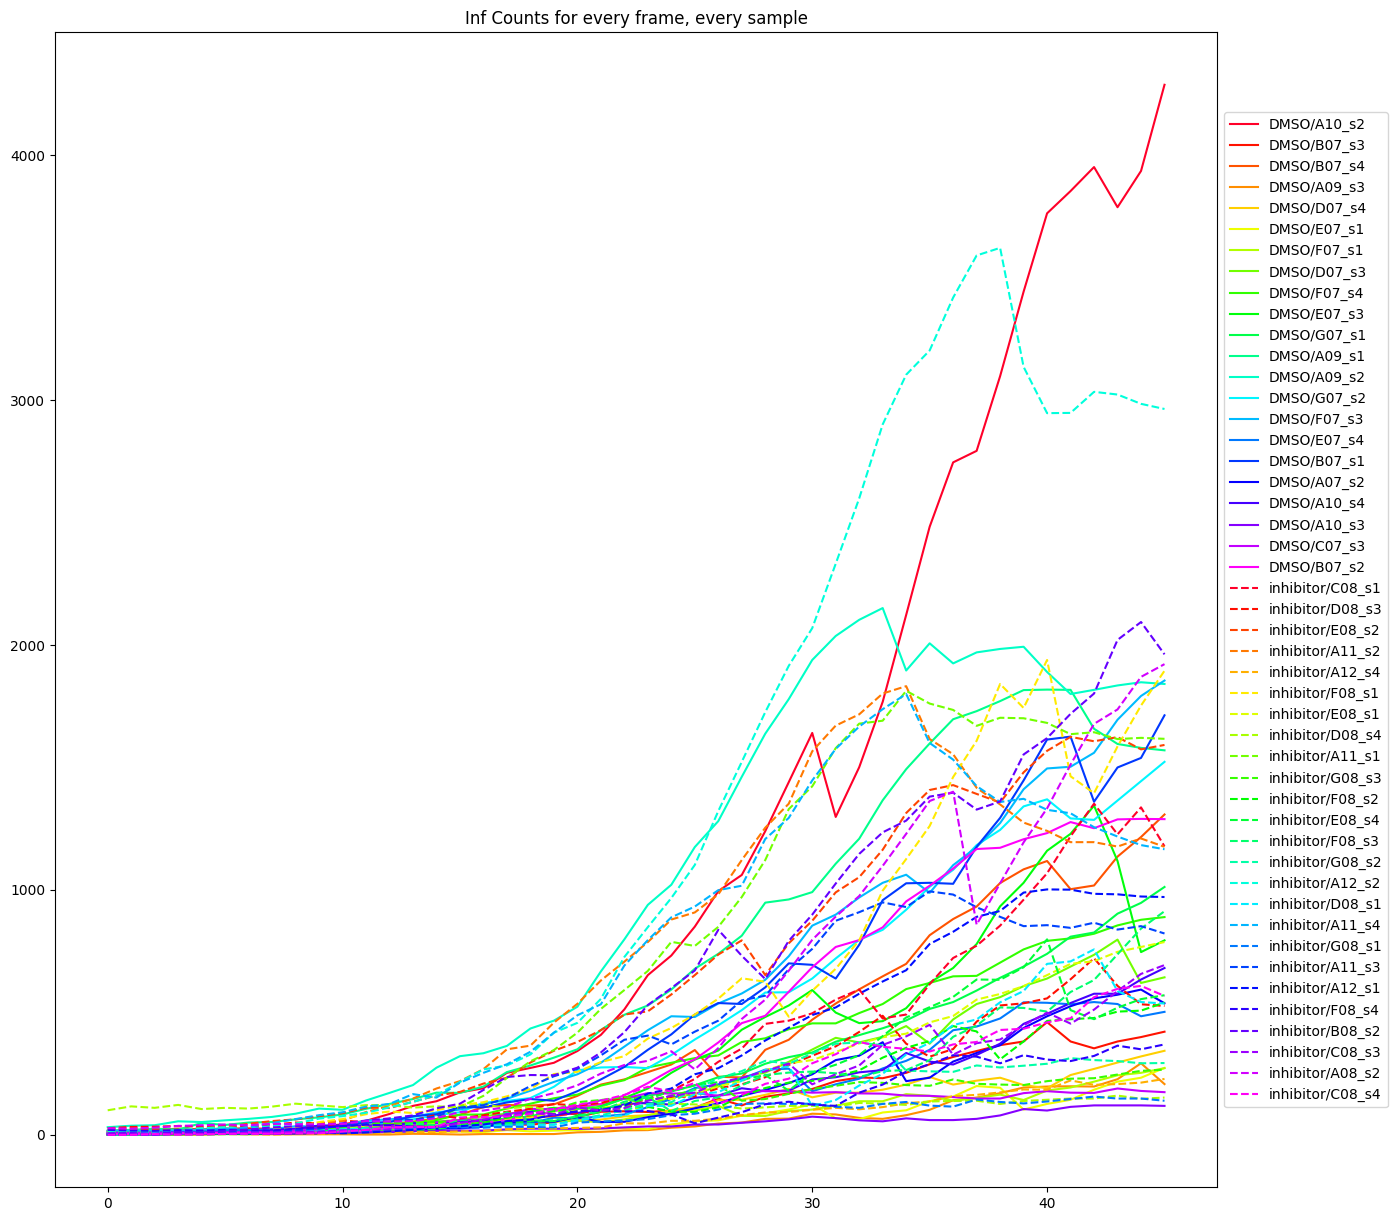

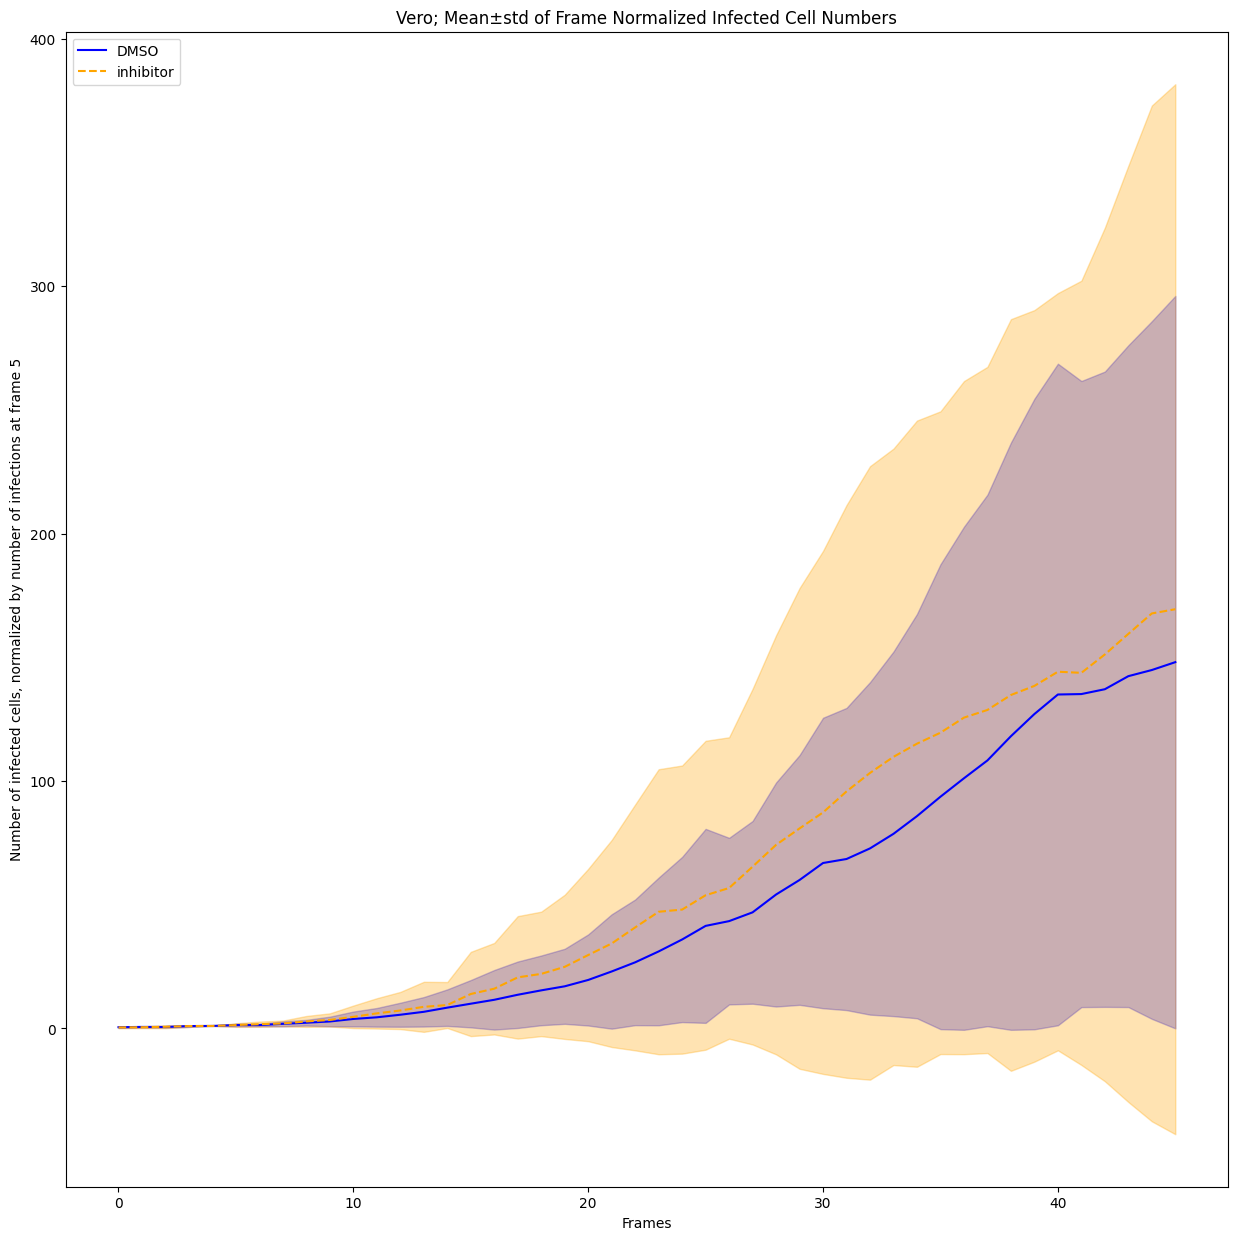

In [12]:
NORMALIZING_FRAME = 4

PROJECT_ROOT = Path("/Users/ashkanhzdr/workspace/ViralTally")
DATASET_ROOT = PROJECT_ROOT / "dataset" / "Sars2Plaque"
SAVE_ROOT = PROJECT_ROOT / "output"
os.makedirs(SAVE_ROOT, exist_ok=True)

dmso_csv_files = get_files_list(DATASET_ROOT / "trackmate" / "Vero_DMSO_wo_bg")
inhibitor_csv_files = get_files_list(DATASET_ROOT / "trackmate" / "Vero_inhibitor_wo_bg")

plot_group_statistics_all_together([dmso_csv_files, inhibitor_csv_files], normalizing_frame=NORMALIZING_FRAME, names=["DMSO", 'inhibitor'], title="Vero; Mean±std of Frame Normalized Infected Cell Numbers", savepath=SAVE_ROOT/f'Vero-frame{NORMALIZING_FRAME}-normalized-wo-bg.pdf')